## Set up

In [98]:
import sys
sys.path.append('./scripts/')
import scipy.ndimage
import torch
import torchvision 
import os
import numpy as np
from PIL import Image
from torchvision.models import feature_extraction 

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [99]:
import get_embeddings
import my_datasets 
import imp
imp.reload(get_embeddings)
imp.reload(my_datasets)

<module 'my_datasets' from '/home/laura/sw-interpretability/scripts/my_datasets.py'>

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [119]:
dataset='ilsvrc12'
layer='Mixed_7b.cat_2'#'Mixed_7c.cat'
compute_embeddings_fresh = True
paths, count, y, idx_to_labels = my_datasets.get_dataset(dataset,lim=10)

print(count, len(paths))

10000 10000


In [120]:
SAVEFOLD0=f'../outputs/{dataset}'
if not os.path.exists(SAVEFOLD0):
    os.mkdir(SAVEFOLD0)

In [121]:
try:
    os.mkdir(f"{SAVEFOLD0}/{layer}/")
except:
    print("Maybe the directory already exists? ")
SAVEFOLD=f"{SAVEFOLD0}/{layer}/"

Maybe the directory already exists? 


## Get data

In [122]:
idx_to_labels

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [123]:
classes = np.unique(y)

In [124]:
model = torch.hub.load('pytorch/vision:v0.9.0', 'inception_v3', pretrained=True)
model.eval()

Using cache found in /home/laura/.cache/torch/hub/pytorch_vision_v0.9.0


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [125]:
 torchvision.models.feature_extraction.get_graph_node_names(model)

(['x',
  'getitem',
  'unsqueeze',
  'mul',
  'add',
  'getitem_1',
  'unsqueeze_1',
  'mul_1',
  'add_1',
  'getitem_2',
  'unsqueeze_2',
  'mul_2',
  'add_2',
  'cat',
  'Conv2d_1a_3x3.conv',
  'Conv2d_1a_3x3.bn',
  'Conv2d_1a_3x3.relu',
  'Conv2d_2a_3x3.conv',
  'Conv2d_2a_3x3.bn',
  'Conv2d_2a_3x3.relu',
  'Conv2d_2b_3x3.conv',
  'Conv2d_2b_3x3.bn',
  'Conv2d_2b_3x3.relu',
  'maxpool1',
  'Conv2d_3b_1x1.conv',
  'Conv2d_3b_1x1.bn',
  'Conv2d_3b_1x1.relu',
  'Conv2d_4a_3x3.conv',
  'Conv2d_4a_3x3.bn',
  'Conv2d_4a_3x3.relu',
  'maxpool2',
  'Mixed_5b.branch1x1.conv',
  'Mixed_5b.branch1x1.bn',
  'Mixed_5b.branch1x1.relu',
  'Mixed_5b.branch5x5_1.conv',
  'Mixed_5b.branch5x5_1.bn',
  'Mixed_5b.branch5x5_1.relu',
  'Mixed_5b.branch5x5_2.conv',
  'Mixed_5b.branch5x5_2.bn',
  'Mixed_5b.branch5x5_2.relu',
  'Mixed_5b.branch3x3dbl_1.conv',
  'Mixed_5b.branch3x3dbl_1.bn',
  'Mixed_5b.branch3x3dbl_1.relu',
  'Mixed_5b.branch3x3dbl_2.conv',
  'Mixed_5b.branch3x3dbl_2.bn',
  'Mixed_5b.branch3

In [126]:
print(layer)
return_nodes={f'{layer}': 'conv', 'avgpool':'avgpool', 'fc':'fc'
             }
model = torchvision.models.feature_extraction.create_feature_extractor(model, return_nodes=return_nodes)

Mixed_7b.cat_2


In [127]:
model

Inception3(
  (Conv2d_1a_3x3): Module(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): Module(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): Module(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): Module(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): Module(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
  

In [128]:
inputs=torch.zeros((8,3,299,299), dtype=torch.float).to(device)
model.to(device)
outs=model(inputs)
dim_c = outs['conv'].shape[1]
dim_w = outs['conv'].shape[2]
dim_h = outs['conv'].shape[3] 

In [129]:
#################################################### test

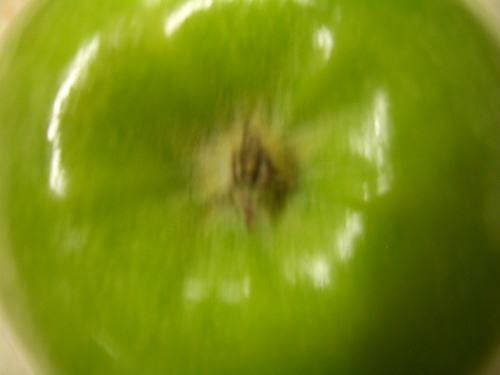

In [130]:
Image.open(paths[9488:9489][0])

In [131]:
SAVEFOLD='../test'

In [133]:
predictions, activations = get_embeddings.get_model_state(model, paths[9488:9489], y[9488:9489], dim_c, dim_w, dim_h, SAVEFOLD=SAVEFOLD)

embeddings shape: (1, 2048)
gradients shape: (1, 2048)
predictions shape: (1, 1000)
0
gradients shape (1, 2048), conv_embs shape (1, 2048), conv_maps.shape (1, 2048, 8, 8)


In [135]:
activations # .shape (1, 2048, 8, 8)

array([[[[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         ...,
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ]],

        [[0.        , 0.        , 0.        , ..., 0.        ,
          0.        , 0.        ],
         [0.        , 0.        , 0.        , ..., 0.        ,
          0.02475736, 0.        ],
         [0.        , 0.        , 0.        , ..., 0.16135295,
          0.        , 0.        ],
         ...,
         [0.        , 0.19705355, 0.02034306, ..., 0.        ,
          0.        , 0. 

In [97]:
finishedc #################################################### test

NameError: name 'finishedc' is not defined

In [15]:
if compute_embeddings_fresh == True:
    get_embeddings.get_model_state(model, paths, y, dim_c, dim_w, dim_h, SAVEFOLD=SAVEFOLD)

embeddings shape: (10000, 2048)
gradients shape: (10000, 2048)
predictions shape: (10000, 1000)
0


Traceback (most recent call last):
  File "/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torch/fx/graph_module.py", line 267, in __call__
    return super(self.cls, obj).__call__(*args, **kwargs)  # type: ignore[misc]
  File "/home/laura/anaconda3/envs/sw-interpretability/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1194, in _call_impl
    return forward_call(*input, **kwargs)
  File "<eval_with_key>.5", line 17, in forward
    cat = torch.cat((add, add_1, add_2), 1);  add = add_1 = add_2 = None
torch.cuda.OutOfMemoryError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 31.75 GiB total capacity; 931.92 MiB already allocated; 8.50 MiB free; 976.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

Call using an FX-traced Module, line 17 of the traced Module's generated forward function:

OutOfMemoryError: CUDA out of memory. Tried to allocate 34.00 MiB (GPU 0; 31.75 GiB total capacity; 931.92 MiB already allocated; 8.50 MiB free; 976.00 MiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [16]:
print("\ndevice: ")
print(device )
print("\ntorch.cuda.is_available(): ")
print(torch.cuda.is_available())
print("\ntorch.cuda.device_count()")
print(torch.cuda.device_count())
print("\ntorch.cuda.get_device_name(0)")
print(torch.cuda.get_device_name(0))
print("\ninputs.is_cuda: ")
print(inputs.is_cuda)


device: 
cuda:0

torch.cuda.is_available(): 
True

torch.cuda.device_count()
1

torch.cuda.get_device_name(0)
Tesla V100-PCIE-32GB

inputs.is_cuda: 
True


In [17]:
print(torch.cuda.get_device_name(1))

AssertionError: Invalid device id

In [19]:
paths[1000]

'/mnt/nas4/datasets/ToReadme/ilsvrc12//train/n01860187/n01860187_10.JPEG'

## Load precomputed results

In [ ]:
gradients_wrt_conv_layer=np.load(f"{SAVEFOLD}/gradients_wrt_conv_layer.npy")
predictions=np.load(f"{SAVEFOLD}/predictions.npy")
conv_maps=np.load(f"{SAVEFOLD}/conv_maps.npy")